In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/yelp_labelled.txt

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/amazon_cells_labelled.txt

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/imdb_labelled.txt

In [5]:
cells_df = pd.read_csv('amazon_cells_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])
yelp_df = pd.read_csv('yelp_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])
imdb_df = pd.read_csv('imdb_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])

In [23]:
df = pd.concat([cells_df,yelp_df,imdb_df]).reset_index(drop=True)
df

,reviews,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2743,I just got bored watching Jessice Lange take h...,0
2744,"Unfortunately, any virtue in this film's produ...",0
2745,"In a word, it is embarrassing.",0
2746,Exceptionally bad!,0


In [72]:
df.isnull().sum()

reviews      0
sentiment    0
dtype: int64

In [70]:
df.index

RangeIndex(start=0, stop=2748, step=1)

In [24]:
df["sentiment"].value_counts()

1    1386
0    1362
Name: sentiment, dtype: int64

In [ ]:
df['reviews'].to_list()

In [26]:
# FUNZIONE CHE MI AGGREGA TUTTI COMANDI DI REGEX PER IL DATA CLEANING
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

In [27]:
# APPLICO LA FUNZIONE SU TUTTO IL TEXT
df["reviews"] = df["reviews"].apply(clean_special_patterns)
df

,reviews,sentiment
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1
...,...,...
2743,just got bored watching jessice lange take her...,0
2744,unfortunately any virtue in this film's produc...,0
2745,inword it is embarrassing,0
2746,exceptionally bad,0


In [28]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [29]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#df["text"][0:10].apply(text_preprocess)
df["reviews"] = df["reviews"].apply(text_preprocess)
df

,reviews,sentiment
0,way plug unlessgo byconverter,0
1,good case excellent value,1
2,great jawbone,1
3,tie charger conversation last minute major pro...,0
4,mic great,1
...,...,...
2743,get bore watch jessice lange clothe,0
2744,unfortunately virtue film production work lose...,0
2745,inword embarrassing,0
2746,exceptionally bad,0


In [30]:
#EDA
cleaned = ' '.join(df['reviews'].to_list())

(-0.5, 799.5, 399.5, -0.5)

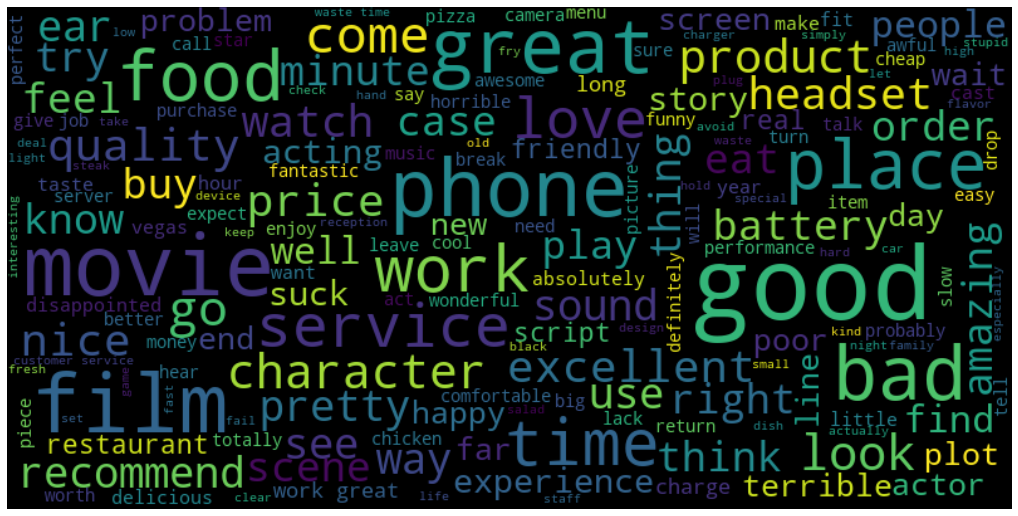

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [32]:
X = df['reviews'] # FEATURES
y = df['sentiment'] # TARGET

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [36]:
labels = ['Negative', 'Positive']

###RANDOMFOREST

In [37]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=667)

In [38]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7147016011644832


Text(69.0, 0.5, 'Actual')

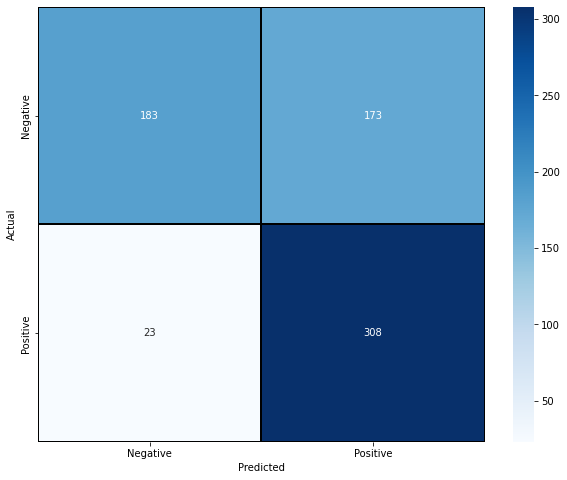

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [40]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.89      0.51      0.65       356
    Positive       0.64      0.93      0.76       331

    accuracy                           0.71       687
   macro avg       0.76      0.72      0.70       687
weighted avg       0.77      0.71      0.70       687



In [41]:
!pip install plot-metric --quiet

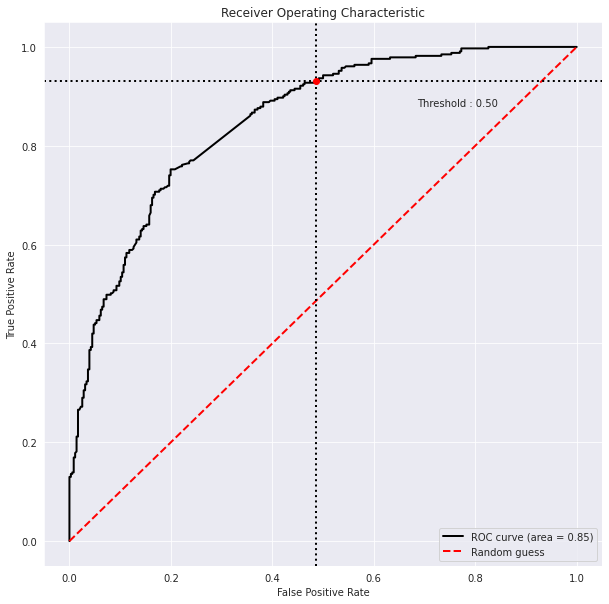

In [42]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

###MULTINOMIAL BN

In [43]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [44]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7787481804949054


Text(69.0, 0.5, 'Actual')

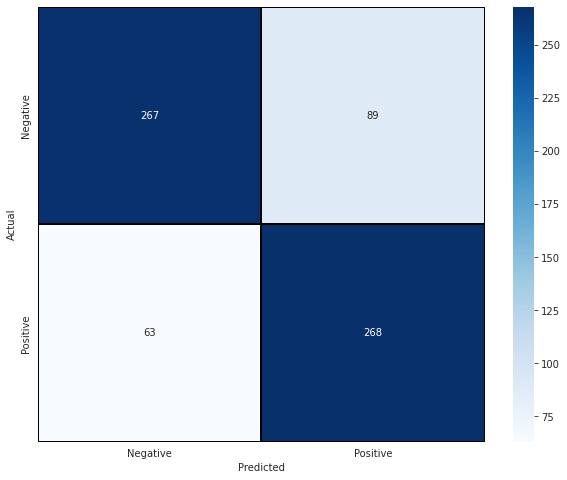

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [46]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.81      0.75      0.78       356
    Positive       0.75      0.81      0.78       331

    accuracy                           0.78       687
   macro avg       0.78      0.78      0.78       687
weighted avg       0.78      0.78      0.78       687



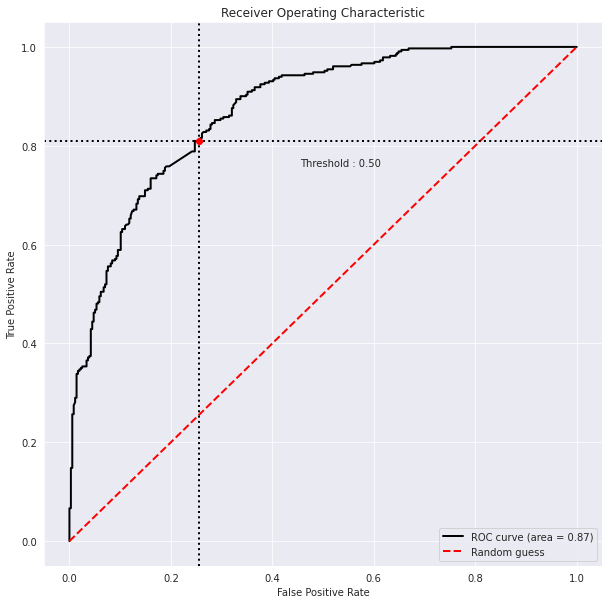

In [47]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

SGD CLASSIFIER

In [48]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7409024745269287


Text(69.0, 0.5, 'Actual')

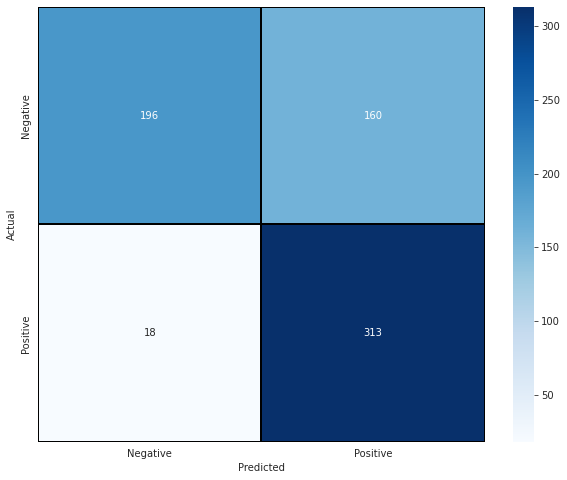

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [50]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.92      0.55      0.69       356
    Positive       0.66      0.95      0.78       331

    accuracy                           0.74       687
   macro avg       0.79      0.75      0.73       687
weighted avg       0.79      0.74      0.73       687



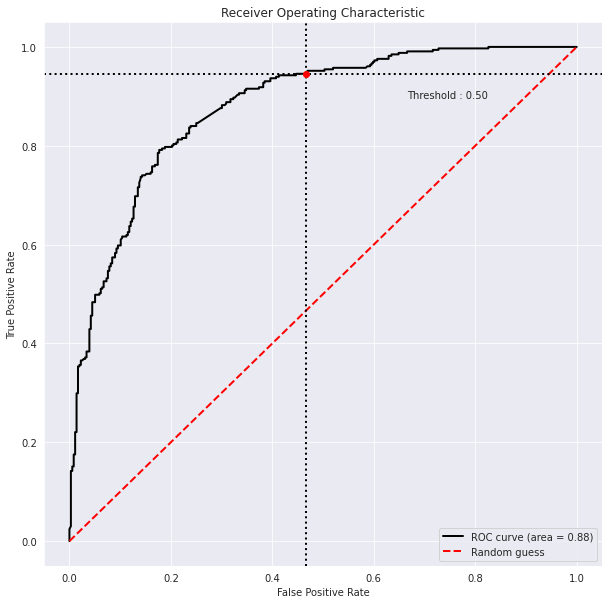

In [51]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

###PIPELINE

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [53]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = MultinomialNB()

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score( y_test,predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7641921397379913


In [73]:
test = pd.Series({'text':'i love you'})

In [74]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('Negative')
else:
  print('Positive')

1
Positive


In [67]:
import joblib

joblib.dump(pipe,'pipeline_classifier_SpaCy.pkl')

['pipeline_classifier_SpaCy.pkl']